# Libraries Install

In [1]:
!pip install nltk -q        # for natural language processing tasks
!pip install tqdm -q        # to display progress bars for loops and tasks
!pip install numpy -q       # to perform math operations and handle numerical data
!pip install pandas -q      # for data manipulation and analysis
!pip install matplotlib -q  # for data visualization and plotting
!pip install seaborn -q     # for statistical data visualization
!pip install textblob -q    # for text processing and sentiment analysis
!pip install wordcloud -q   # to create word cloud visualizations
!pip install scikit-learn -q # for machine learning algorithms and tools
!pip install transformers -q # for bert model

# Reading Data

In [ ]:
import os
from google.colab import drive

# Mounting drive
drive.mount('/content/drive')

# Changing directory
project_path = '/content/drive/Aspect Based Sentiment Analysis'
os.chdir(project_path)

print("Current working directory:", os.getcwd())

In [3]:
import json
from tqdm import tqdm

all_records = []
max_records_to_read = 10000

# Opening file
file_path = "Data/Cell_Phones_and_Accessories.jsonl"
with open(file_path, 'r') as fp:

    for line in tqdm(fp):

      # Checking if max records reached
      if len(all_records) >= max_records_to_read:
        break
      record = json.loads(line.strip())

      # Dropping unnecessary information
      record.pop("images")
      record.pop("user_id")
      record.pop("asin")
      record.pop("parent_asin")

      # Storing record
      all_records.append(record)

print(f"Total records: {len(all_records)}")

10000it [00:00, 12099.71it/s]

Total records: 10000


In [4]:
import pandas as pd

# Converting to a pandas DataFrame
df = pd.DataFrame(all_records)
print(df.head().to_markdown())

# Deleting records list for memory save
del(all_records)

|    |   rating | title                               | text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [5]:
df.shape

(10000, 6)

In [6]:
# Saving the DataFrame to a CSV
newfile_path = "Data/loaded_data.csv"
df.to_csv(newfile_path, index=False)
print(f"DataFrame saved to {newfile_path}")

DataFrame saved to Data/loaded_data.csv


# Data Preparation

In [7]:
# Checking data types and null values
print(df.info())
print("\n\n\n")

# Statistical summary
print(df.describe().to_markdown())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rating             10000 non-null  float64
 1   title              10000 non-null  object 
 2   text               10000 non-null  object 
 3   timestamp          10000 non-null  int64  
 4   helpful_vote       10000 non-null  int64  
 5   verified_purchase  10000 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(2)
memory usage: 400.5+ KB
None




|       |     rating |       timestamp |   helpful_vote |
|:------|-----------:|----------------:|---------------:|
| count | 10000      | 10000           |    10000       |
| mean  |     4.191  |     1.56046e+12 |        0.8364  |
| std   |     1.3028 |     8.51081e+10 |        7.02216 |
| min   |     1      |     1.05279e+12 |        0       |
| 25%   |     4      |     1.50403e+12 |        0       |
| 50%   |     5      

In [8]:
# Dropping rows with null values
df.dropna(subset=['text'], inplace=True)

# Converting from milliseconds to seconds
df['timestamp'] = df['timestamp'] // 1000

# Converting timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Dropping duplicates
df.drop_duplicates(subset=['text'], inplace=True)

In [9]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Downloading NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Preprocessing Text
df['cleaned_title'] = df['title'].apply(preprocess_text)
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Combining the cleaned title and text
df['combined_text'] = df['cleaned_title'] + ' ' + df['cleaned_text']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [10]:
# Dropping NAN if any
df.dropna(inplace=True)

# Data Analysis

## a) Sentiment Analysis

In [11]:
from textblob import TextBlob

# Function to calculate sentiment
def get_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity  # Measure the positivity/negativity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Sentiment
df['sentiment'] = df['combined_text'].apply(get_sentiment)
print(df[['sentiment', 'combined_text']].head().to_markdown())

|    | sentiment   | combined_text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
|---:|:------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

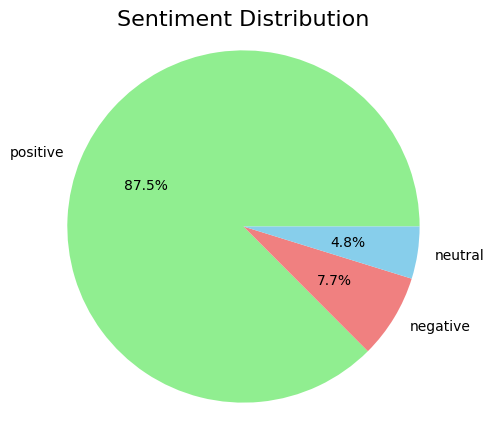

In [12]:
import matplotlib.pyplot as plt

sentiment_counts = df['sentiment'].value_counts()

# Create the pie chart
plt.figure(figsize=(5, 5))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=0, colors=['lightgreen', 'lightcoral', 'skyblue'])
plt.title('Sentiment Distribution', fontsize=16)
plt.axis('equal')
plt.show()

<ipython-input-13-402ecbc81eb4>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentiment_rating, x='sentiment', y='rating', palette='viridis')


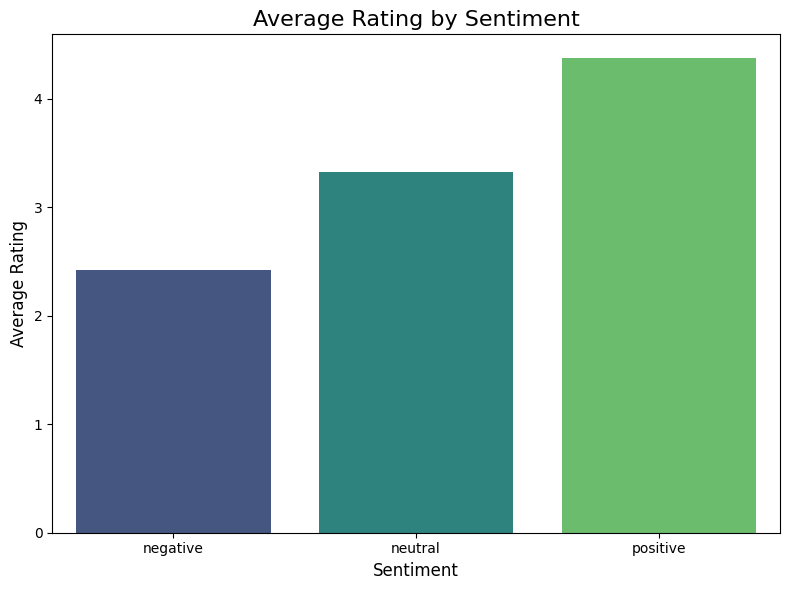

<ipython-input-13-402ecbc81eb4>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='sentiment', y='rating', palette='viridis')


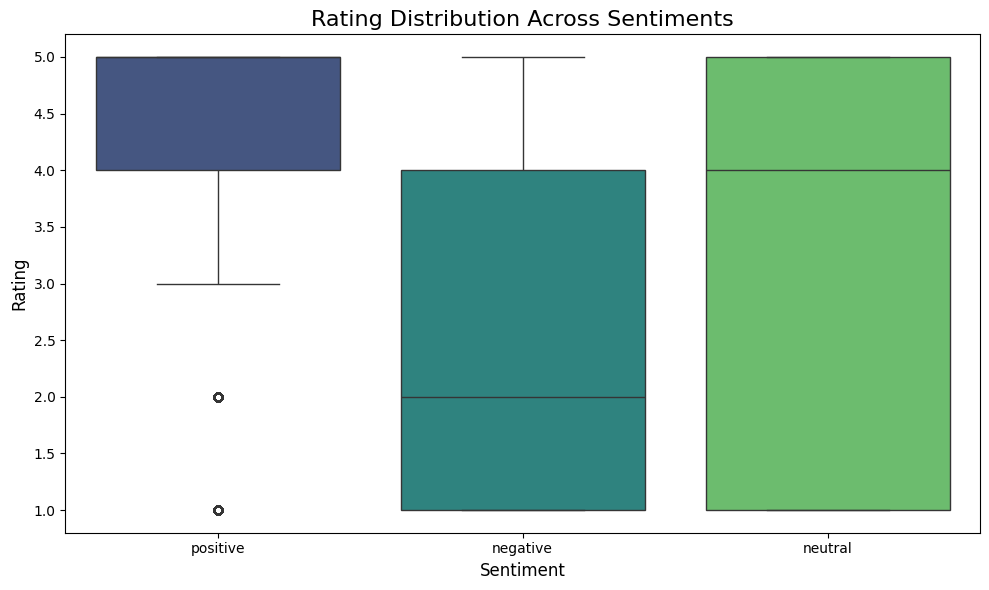

In [13]:
import seaborn as sns

# Grouping data by sentiment and calculating the mean rating for each sentiment category
sentiment_rating = df.groupby('sentiment')['rating'].mean().reset_index()

# Plotting average rating for each sentiment
plt.figure(figsize=(8, 6))
sns.barplot(data=sentiment_rating, x='sentiment', y='rating', palette='viridis')
plt.title('Average Rating by Sentiment', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.tight_layout()
plt.show()

# Analyzing rating distribution across sentiments
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='sentiment', y='rating', palette='viridis')
plt.title('Rating Distribution Across Sentiments', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.tight_layout()
plt.show()

<ipython-input-14-42dc8bae4035>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=helpful_votes_sentiment, x='sentiment', y='helpful_vote', palette='viridis')


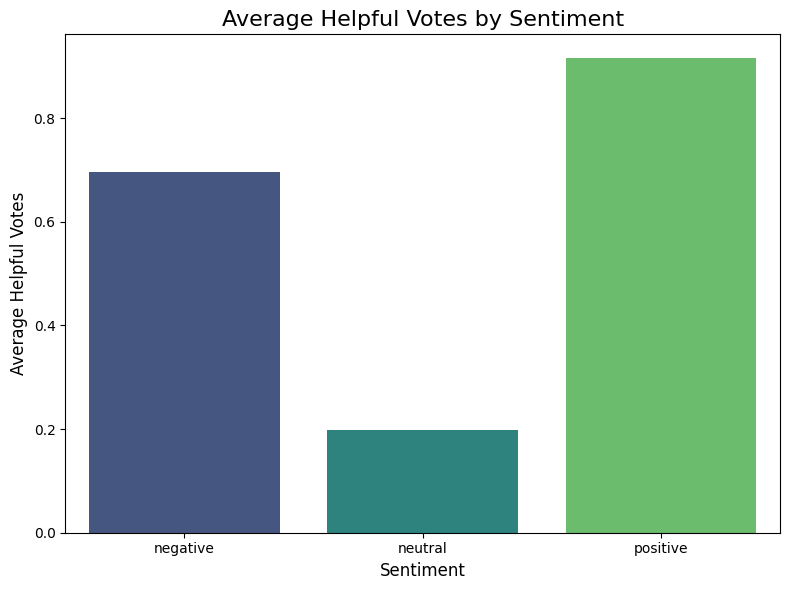

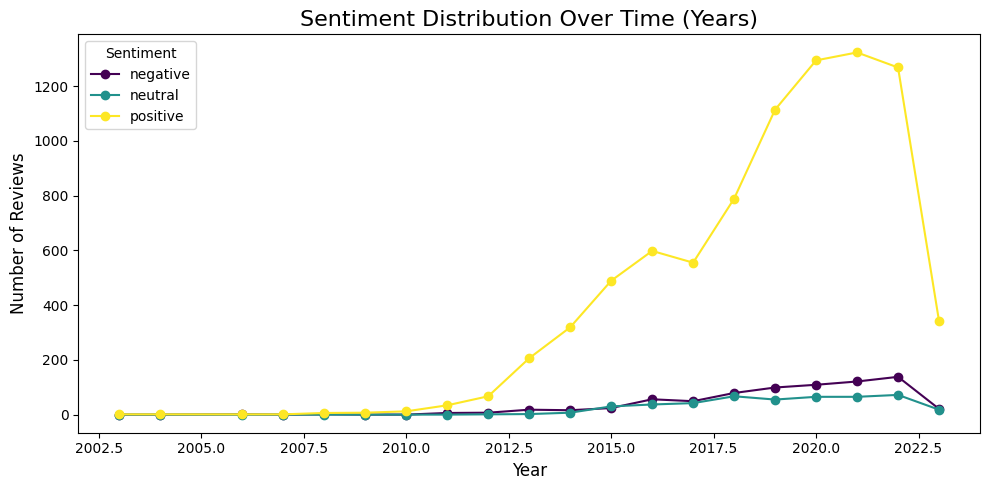

In [14]:
# Analyze and plot helpful votes by sentiment
helpful_votes_sentiment = df.groupby('sentiment')['helpful_vote'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=helpful_votes_sentiment, x='sentiment', y='helpful_vote', palette='viridis')
plt.title('Average Helpful Votes by Sentiment', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Average Helpful Votes', fontsize=12)
plt.tight_layout()
plt.show()

# Analyze sentiment distribution over time (using year)
df['year'] = df['timestamp'].dt.year
sentiment_year = df.groupby(['year', 'sentiment']).size().unstack(fill_value=0)

sentiment_year.plot(kind='line', figsize=(10, 5), colormap='viridis', marker='o')
plt.title('Sentiment Distribution Over Time (Years)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


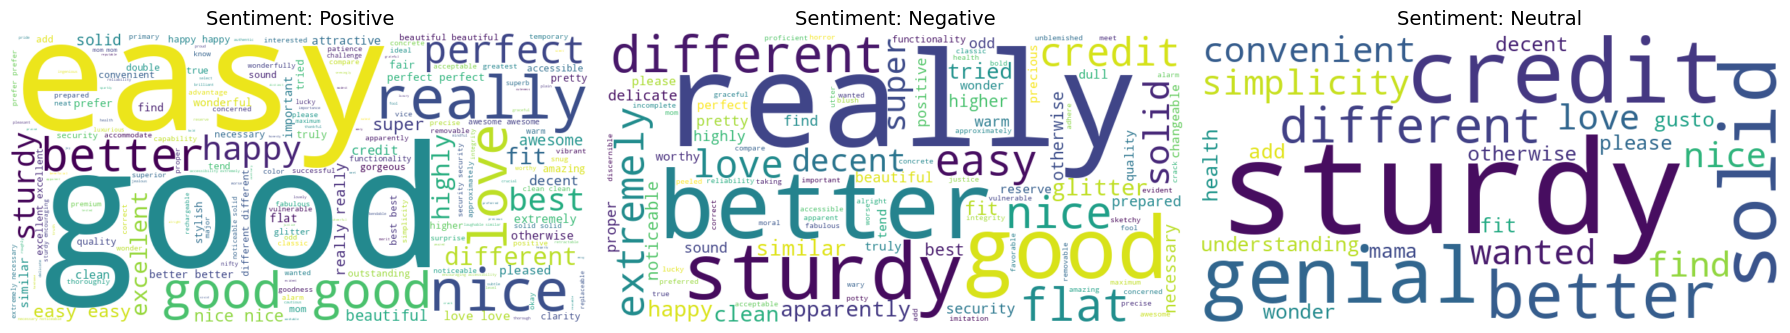

In [15]:
from nltk.corpus import wordnet, sentiwordnet as swn, stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

# Function to get WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Filter words based on emotional content
def filter_emotional_words(texts):
    positive_words = []
    negative_words = []
    for text in texts:
        tokens = word_tokenize(text.lower())
        for word, pos_tag in nltk.pos_tag(tokens):
            pos = get_wordnet_pos(pos_tag)
            if pos:
                try:
                    synset = swn.senti_synset(f"{word}.{pos}.01")
                    if synset.obj_score() <= 0.49:  # Filter out neutral/objective words
                        if synset.pos_score() > synset.neg_score():
                            positive_words.append(word)
                        elif synset.neg_score() > synset.pos_score():
                            negative_words.append(word)
                except:
                    pass
    return positive_words, negative_words

# Separate texts by sentiment
sentiment_texts = {
    sentiment: df[df['sentiment'] == sentiment]['combined_text'].tolist()
    for sentiment in df['sentiment'].unique()
}

# Prepare word clouds
fig, axes = plt.subplots(1, len(sentiment_texts), figsize=(18, 6), sharex=True, sharey=True)

for ax, (sentiment, texts) in zip(axes, sentiment_texts.items()):
    positive_words, _ = filter_emotional_words(texts)  # Focus on positive words for now
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        stopwords=set(stopwords.words('english'))
    ).generate(' '.join(positive_words))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Sentiment: {sentiment.capitalize()}", fontsize=14)

plt.tight_layout()
plt.show()


# Topic Modeling Analysis

In [16]:
from transformers import pipeline
from tqdm import tqdm

df = df.sample(5000)
categories = ['Phone Case', 'Phone Holder', 'Phone Stand', 'Phone Battery', 'Screen Protector', 'Phone Charger', 'Electric Stove']
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

results = []
for index, row in tqdm(df.iterrows()):
  text = row['combined_text']
  result = classifier(text, categories)
  predicted_class = result['labels'][0]  # Get the top predicted label
  results.append(predicted_class)

df['Topic'] = results

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
10it [00:02,  6.33it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
5000it [12:02,  6.92it/s]


Topic
Screen Protector    1740
Phone Case          1092
Phone Holder         890
Phone Charger        574
Electric Stove       539
Phone Battery         92
Phone Stand           73
Name: count, dtype: int64


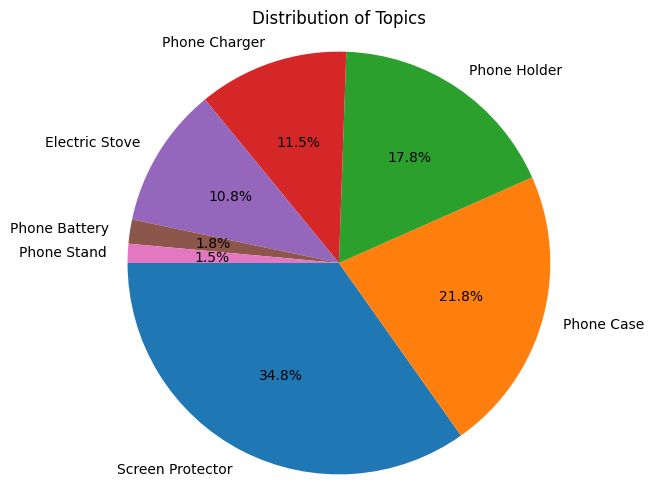

In [17]:
topic_distribution = df['Topic'].value_counts()
print(topic_distribution)

plt.figure(figsize=(6,6))
plt.pie(topic_distribution, labels=topic_distribution.index, autopct='%1.1f%%', startangle=180)
plt.title('Distribution of Topics')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [18]:
crosstab = pd.crosstab(df['Topic'], df['sentiment'])
print(crosstab)

sentiment         negative  neutral  positive
Topic                                        
Electric Stove          31       39       469
Phone Battery           10        1        81
Phone Case              62       17      1013
Phone Charger           47       29       498
Phone Holder           123       67       700
Phone Stand              5        2        66
Screen Protector       128       95      1517


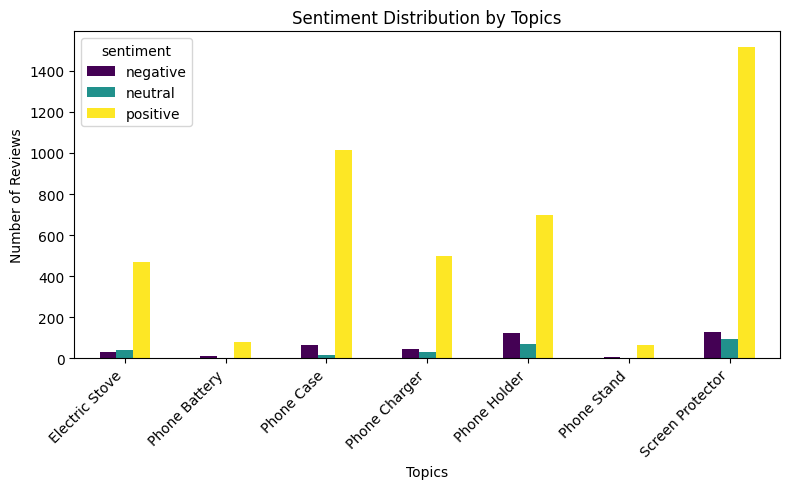

In [19]:
# Stacked bar chart
crosstab.plot(kind='bar', stacked=False, figsize=(8, 5), colormap='viridis')
plt.title('Sentiment Distribution by Topics')
plt.ylabel('Number of Reviews')
plt.xlabel('Topics')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Machine Learning Model

In [20]:
df.to_csv("Data/topic_data.csv", index=False)

In [21]:
# Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [22]:
# Converting text to numbers using TFIDF
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(df['combined_text']).toarray()
y = df[['sentiment', "Topic"]]

# Spliting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
y[]

,sentiment,Topic
7228,positive,Phone Holder
6553,positive,Phone Case
6526,positive,Phone Holder
3848,positive,Electric Stove
4156,positive,Phone Case
...,...,...
1538,positive,Phone Case
2651,positive,Screen Protector
1834,positive,Screen Protector
5710,positive,Phone Holder


sentiment
positive    4344
negative     406
neutral      250
Name: count, dtype: int64


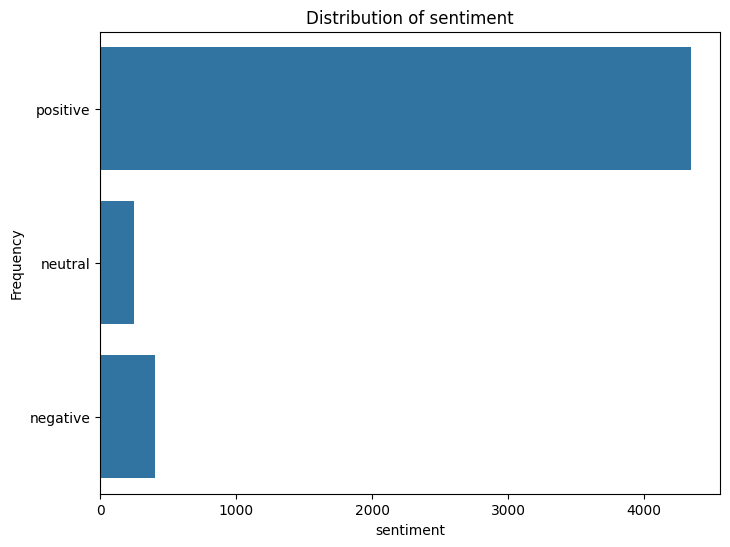

Topic
Screen Protector    1740
Phone Case          1092
Phone Holder         890
Phone Charger        574
Electric Stove       539
Phone Battery         92
Phone Stand           73
Name: count, dtype: int64


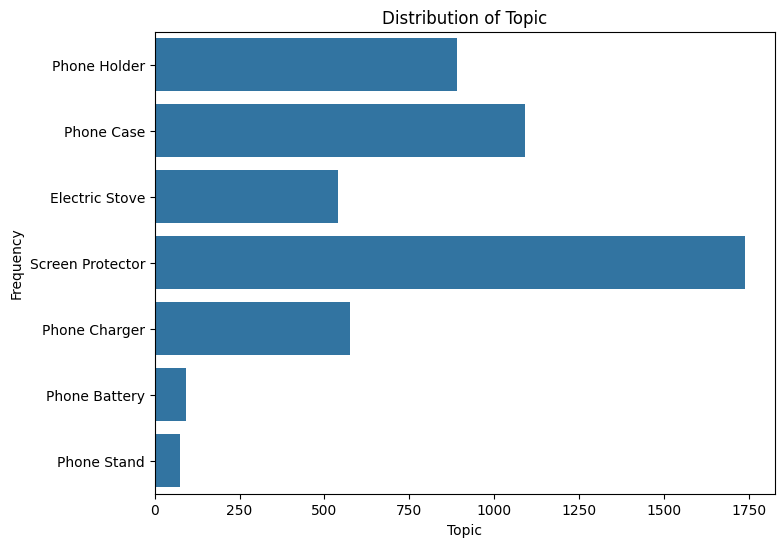

In [37]:
def plot_feature_distribution(df, column_name):

  # Print descriptive statistics
  print(df[column_name].value_counts())

  # Plot distribution
  plt.figure(figsize=(8, 6))
  sns.countplot(df[column_name])
  plt.title(f'Distribution of {column_name}')
  plt.xlabel(column_name)
  plt.ylabel('Frequency')
  plt.show()

plot_feature_distribution(y, "sentiment")
plot_feature_distribution(y, "Topic")

In [24]:
def calculate_metrics(y_test, y_pred, name):

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    # Print metrics
    print(f"Model: {name}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Plot confusion matrix
    y_test.unique()
    cm = confusion_matrix(y_test, y_pred)
    if "Sentiment" in name:
      figsize = (4, 3)
    else:
      figsize = (7, 5)

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=y_test.unique(), yticklabels=y_test.unique())
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    return {"model": name, "accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1}

# Evaluation function with confusion matrix plotting
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_sentiment = [pred[0] for pred in y_pred]
    y_pred_topic = [pred[1] for pred in y_pred]

    res_sentiment = calculate_metrics(y_test['sentiment'], y_pred_sentiment, name + " - Sentiment")
    res_topic = calculate_metrics(y_test['Topic'], y_pred_topic, name + " - Topic")

    return [res_sentiment, res_topic]

Training Random Forest...
Model: Random Forest - Sentiment
Accuracy: 0.903
Precision: 0.8956864301276066
Recall: 0.903
F1 Score: 0.8842995493568352

Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.26      0.41        72
     neutral       0.56      0.36      0.44        53
    positive       0.92      0.99      0.95       875

    accuracy                           0.90      1000
   macro avg       0.79      0.54      0.60      1000
weighted avg       0.90      0.90      0.88      1000



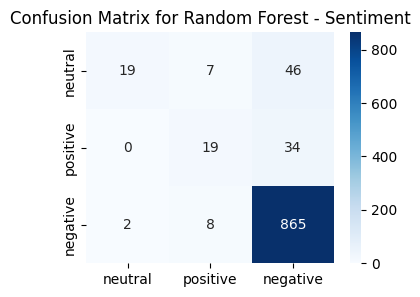

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Model: Random Forest - Topic
Accuracy: 0.711
Precision: 0.7051206346737579
Recall: 0.711
F1 Score: 0.6984061682173787

Classification Report:
                   precision    recall  f1-score   support

  Electric Stove       0.57      0.50      0.53       101
   Phone Battery       1.00      0.06      0.11        17
      Phone Case       0.86      0.82      0.84       219
   Phone Charger       0.67      0.64      0.66       123
    Phone Holder       0.68      0.64      0.66       168
     Phone Stand       0.00      0.00      0.00        16
Screen Protector       0.69      0.82      0.75       356

        accuracy                           0.71      1000
       macro avg       0.64      0.50      0.51      1000
    weighted avg       0.71      0.71      0.70      1000



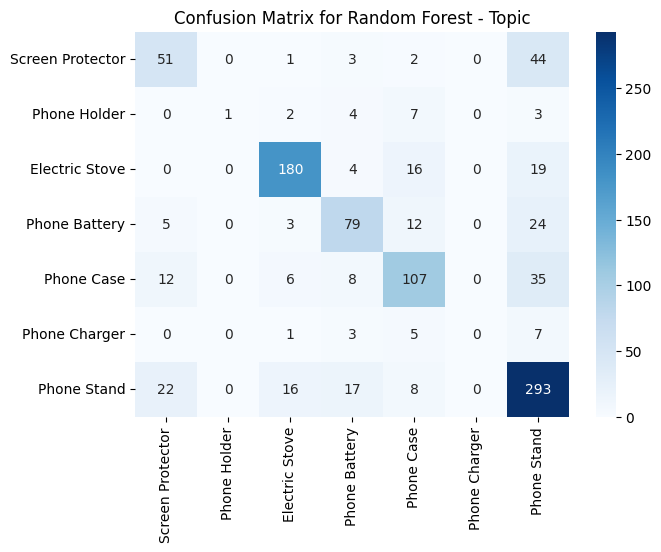

Training Logistic Regression...
Model: Logistic Regression - Sentiment
Accuracy: 0.897
Precision: 0.9020239252814739
Recall: 0.897
F1 Score: 0.8638003759247026

Classification Report:
               precision    recall  f1-score   support

    negative       1.00      0.21      0.34        72
     neutral       0.88      0.13      0.23        53
    positive       0.90      1.00      0.94       875

    accuracy                           0.90      1000
   macro avg       0.92      0.45      0.51      1000
weighted avg       0.90      0.90      0.86      1000



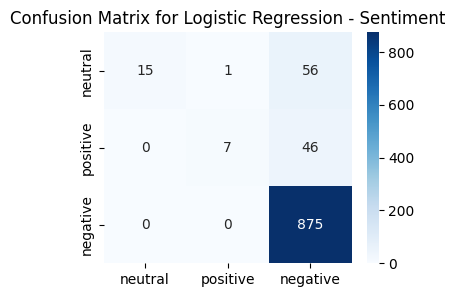

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Model: Logistic Regression - Topic
Accuracy: 0.656
Precision: 0.6487484210795251
Recall: 0.656
F1 Score: 0.635352746140325

Classification Report:
                   precision    recall  f1-score   support

  Electric Stove       0.58      0.31      0.40       101
   Phone Battery       0.40      0.12      0.18        17
      Phone Case       0.77      0.74      0.75       219
   Phone Charger       0.74      0.43      0.54       123
    Phone Holder       0.61      0.63      0.62       168
     Phone Stand       0.00      0.00      0.00        16
Screen Protector       0.62      0.85      0.72       356

        accuracy                           0.66      1000
       macro avg       0.53      0.44      0.46      1000
    weighted avg       0.65      0.66      0.64      1000



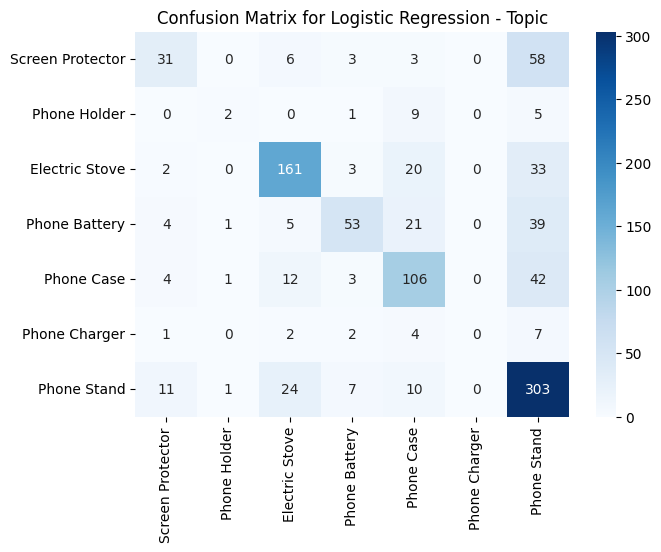

Training K-Nearest Neighbors...
Model: K-Nearest Neighbors - Sentiment
Accuracy: 0.149
Precision: 0.8685558857502887
Recall: 0.149
F1 Score: 0.18733087822588138

Classification Report:
               precision    recall  f1-score   support

    negative       0.67      0.03      0.05        72
     neutral       0.05      0.89      0.10        53
    positive       0.93      0.11      0.20       875

    accuracy                           0.15      1000
   macro avg       0.55      0.34      0.12      1000
weighted avg       0.87      0.15      0.19      1000



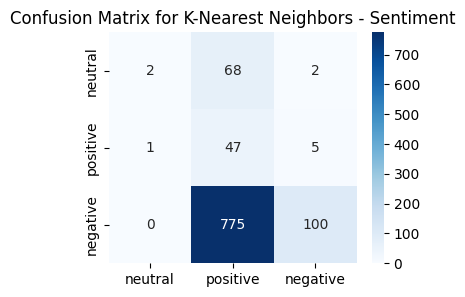

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Model: K-Nearest Neighbors - Topic
Accuracy: 0.132
Precision: 0.4708524647187438
Recall: 0.132
F1 Score: 0.08685697140976098

Classification Report:
                   precision    recall  f1-score   support

  Electric Stove       0.10      0.93      0.18       101
   Phone Battery       0.00      0.00      0.00        17
      Phone Case       0.17      0.01      0.02       219
   Phone Charger       1.00      0.02      0.03       123
    Phone Holder       0.17      0.01      0.01       168
     Phone Stand       0.00      0.00      0.00        16
Screen Protector       0.77      0.09      0.17       356

        accuracy                           0.13      1000
       macro avg       0.31      0.15      0.06      1000
    weighted avg       0.47      0.13      0.09      1000



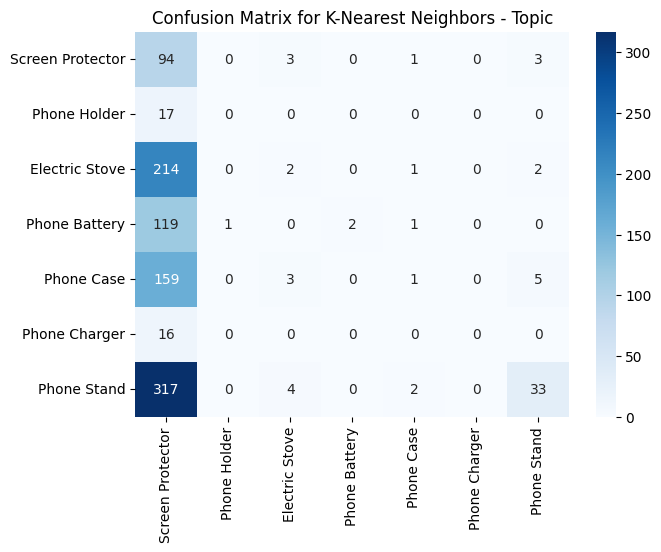

In [25]:
# Models to train
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
}

# Converting models to multiclass
from sklearn.multioutput import MultiOutputClassifier

# Wrappring models in MultiOutputClassifier
models = {name: MultiOutputClassifier(model) for name, model in models.items()}

# Train and evaluate all models
results = []
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    results.extend(evaluate_model(name, model, X_test, y_test))

|    | model                           |   accuracy |   precision |   recall |   f1_score |
|---:|:--------------------------------|-----------:|------------:|---------:|-----------:|
|  0 | Random Forest - Sentiment       |      0.903 |    0.895686 |    0.903 |   0.8843   |
|  1 | Random Forest - Topic           |      0.711 |    0.705121 |    0.711 |   0.698406 |
|  2 | Logistic Regression - Sentiment |      0.897 |    0.902024 |    0.897 |   0.8638   |
|  3 | Logistic Regression - Topic     |      0.656 |    0.648748 |    0.656 |   0.635353 |
|  4 | K-Nearest Neighbors - Sentiment |      0.149 |    0.868556 |    0.149 |   0.187331 |
|  5 | K-Nearest Neighbors - Topic     |      0.132 |    0.470852 |    0.132 |   0.086857 |


<ipython-input-26-9b0eceb4d984>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='model', y='f1_score', palette='viridis')


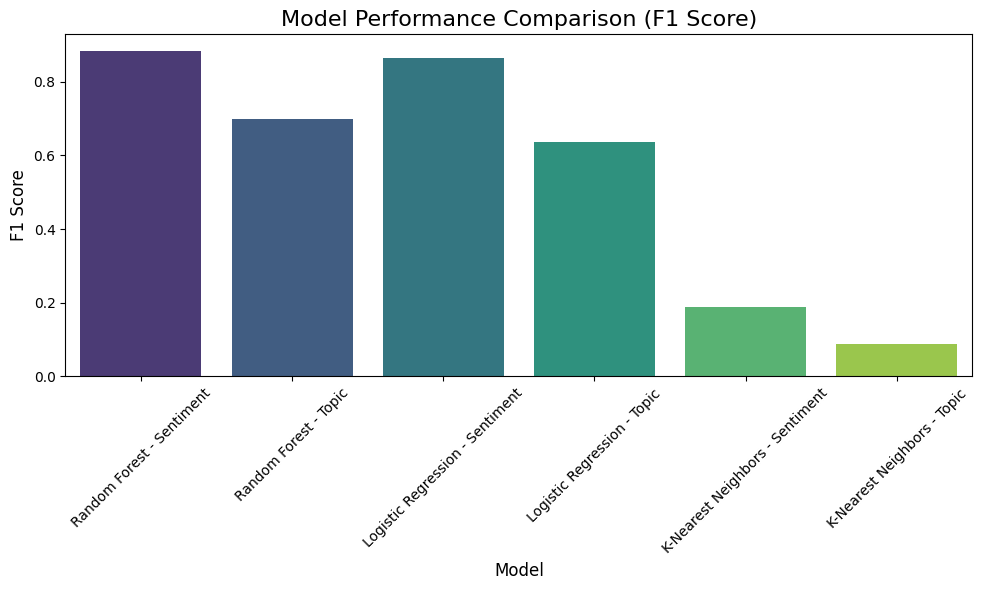

In [26]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df.to_markdown())

# Plot model performance
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='model', y='f1_score', palette='viridis')
plt.title('Model Performance Comparison (F1 Score)', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Balanced Data Model

In [27]:
import numpy as np
from imblearn.over_sampling import SMOTE

# Combining multi-output targets into a single label
y_combined = y['sentiment'].astype(str) + "_" + y['Topic'].astype(str)
y_combined.reset_index(drop=True, inplace=True)

# Dropping invalid classes
cats = y_combined.value_counts()
invalid_classes = cats[cats<30].index

invalid_indexes = y_combined[y_combined.isin(invalid_classes)].index
X_new = np.delete(X, invalid_indexes, axis=0)
y_combined = y_combined.drop(invalid_indexes)

In [28]:
# Applying SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_combined_resampled = smote.fit_resample(X_new, y_combined)

# Split the combined label
y_resampled = y_combined_resampled.str.split("_", expand=True)
y_resampled.columns = ['sentiment', 'Topic']

# Train-test split on the balanced data
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


sentiment
positive    10619
negative     7585
neutral      4551
Name: count, dtype: int64


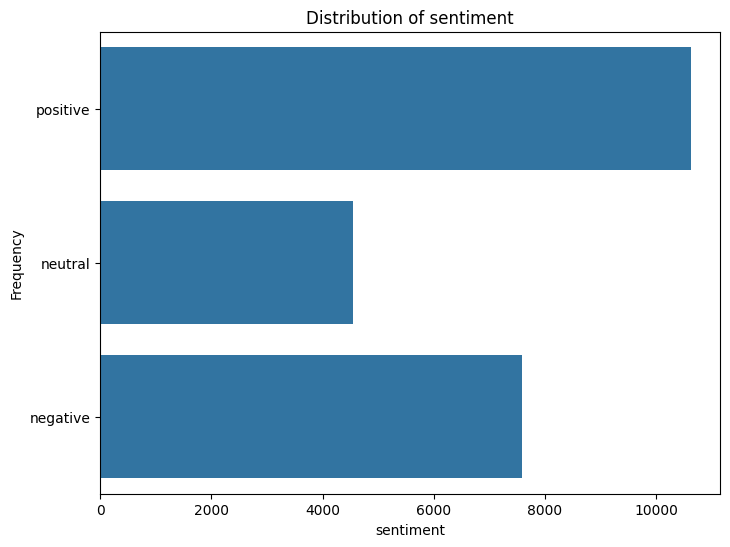

Topic
Phone Holder        4551
Electric Stove      4551
Screen Protector    4551
Phone Case          3034
Phone Charger       3034
Phone Battery       1517
Phone Stand         1517
Name: count, dtype: int64


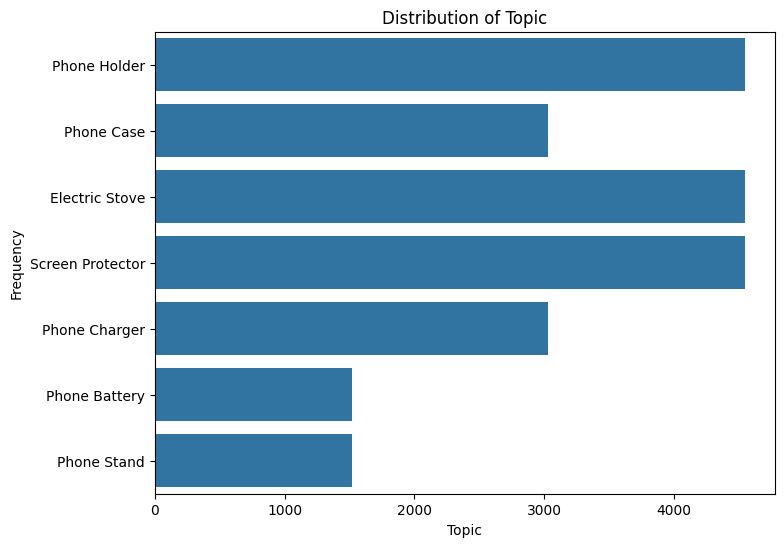

In [38]:
plot_feature_distribution(y_resampled, "sentiment")
plot_feature_distribution(y_resampled, "Topic")

Training Random Forest on balanced data...
Model: Random Forest - Sentiment
Accuracy: 0.995825093386069
Precision: 0.9958420748852637
Recall: 0.995825093386069
F1 Score: 0.9958244872132405

Classification Report:
               precision    recall  f1-score   support

    negative       0.99      1.00      1.00      1523
     neutral       0.99      1.00      1.00       911
    positive       1.00      0.99      1.00      2117

    accuracy                           1.00      4551
   macro avg       0.99      1.00      1.00      4551
weighted avg       1.00      1.00      1.00      4551



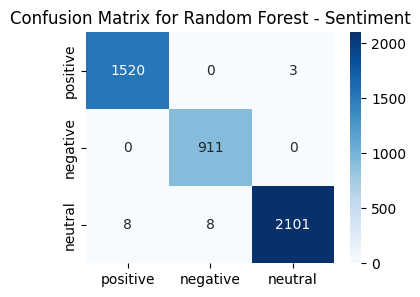

Model: Random Forest - Topic
Accuracy: 0.950120852559877
Precision: 0.9509300784771876
Recall: 0.950120852559877
F1 Score: 0.9499426387768197

Classification Report:
                   precision    recall  f1-score   support

  Electric Stove       0.91      0.98      0.95       901
   Phone Battery       1.00      1.00      1.00       299
      Phone Case       0.98      0.92      0.95       620
   Phone Charger       0.97      0.97      0.97       615
    Phone Holder       0.93      0.96      0.94       874
     Phone Stand       1.00      0.99      1.00       305
Screen Protector       0.95      0.89      0.92       937

        accuracy                           0.95      4551
       macro avg       0.96      0.96      0.96      4551
    weighted avg       0.95      0.95      0.95      4551



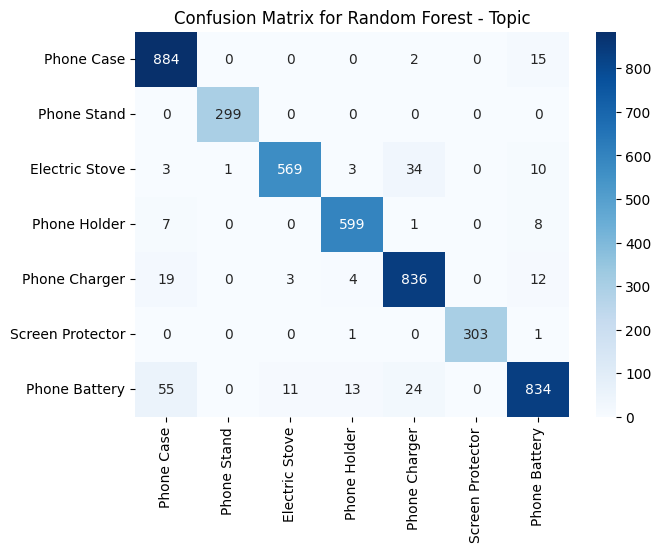

Training Logistic Regression on balanced data...
Model: Logistic Regression - Sentiment
Accuracy: 0.987695012085256
Precision: 0.9878976241298987
Recall: 0.987695012085256
F1 Score: 0.9876841287847047

Classification Report:
               precision    recall  f1-score   support

    negative       0.98      1.00      0.99      1523
     neutral       0.98      1.00      0.99       911
    positive       1.00      0.98      0.99      2117

    accuracy                           0.99      4551
   macro avg       0.99      0.99      0.99      4551
weighted avg       0.99      0.99      0.99      4551



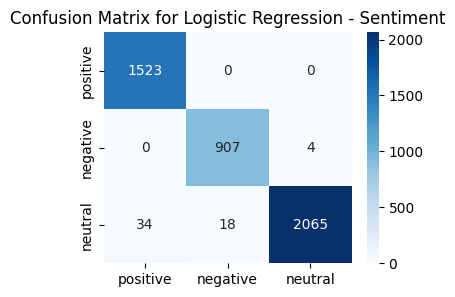

Model: Logistic Regression - Topic
Accuracy: 0.9081520544935179
Precision: 0.9097399186098302
Recall: 0.9081520544935179
F1 Score: 0.9076655774704531

Classification Report:
                   precision    recall  f1-score   support

  Electric Stove       0.85      0.96      0.90       901
   Phone Battery       0.95      1.00      0.97       299
      Phone Case       0.93      0.87      0.90       620
   Phone Charger       0.95      0.91      0.93       615
    Phone Holder       0.91      0.91      0.91       874
     Phone Stand       0.96      0.99      0.97       305
Screen Protector       0.90      0.83      0.87       937

        accuracy                           0.91      4551
       macro avg       0.92      0.92      0.92      4551
    weighted avg       0.91      0.91      0.91      4551



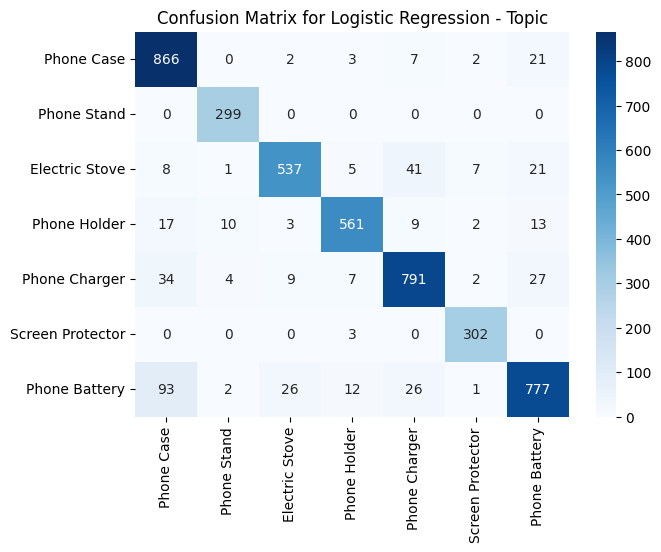

Training K-Nearest Neighbors on balanced data...
Model: K-Nearest Neighbors - Sentiment
Accuracy: 0.8301472203911229
Precision: 0.9064263726837389
Recall: 0.8301472203911229
F1 Score: 0.8358713103320594

Classification Report:
               precision    recall  f1-score   support

    negative       0.99      1.00      1.00      1523
     neutral       0.54      1.00      0.71       911
    positive       1.00      0.63      0.78      2117

    accuracy                           0.83      4551
   macro avg       0.85      0.88      0.83      4551
weighted avg       0.91      0.83      0.84      4551



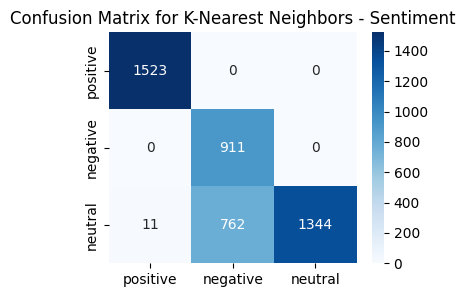

Model: K-Nearest Neighbors - Topic
Accuracy: 0.8549769281476599
Precision: 0.8724783755259841
Recall: 0.8549769281476599
F1 Score: 0.8536545718396256

Classification Report:
                   precision    recall  f1-score   support

  Electric Stove       0.73      0.97      0.83       901
   Phone Battery       1.00      1.00      1.00       299
      Phone Case       0.98      0.63      0.77       620
   Phone Charger       0.98      0.87      0.92       615
    Phone Holder       0.80      0.88      0.84       874
     Phone Stand       0.99      1.00      1.00       305
Screen Protector       0.86      0.76      0.81       937

        accuracy                           0.85      4551
       macro avg       0.91      0.87      0.88      4551
    weighted avg       0.87      0.85      0.85      4551



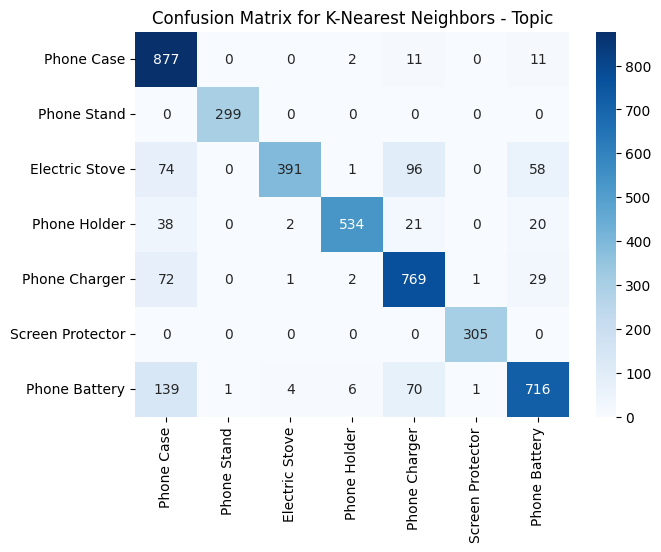

In [30]:
# Train and evaluate models on balanced data
balanced_results = []
for name, model in models.items():
    print(f"Training {name} on balanced data...")
    model.fit(X_train_balanced, y_train_balanced)
    balanced_results.extend(evaluate_model(name, model, X_test_balanced, y_test_balanced))

|    | model                           |   accuracy |   precision |   recall |   f1_score |
|---:|:--------------------------------|-----------:|------------:|---------:|-----------:|
|  0 | Random Forest - Sentiment       |   0.995825 |    0.995842 | 0.995825 |   0.995824 |
|  1 | Random Forest - Topic           |   0.950121 |    0.95093  | 0.950121 |   0.949943 |
|  2 | Logistic Regression - Sentiment |   0.987695 |    0.987898 | 0.987695 |   0.987684 |
|  3 | Logistic Regression - Topic     |   0.908152 |    0.90974  | 0.908152 |   0.907666 |
|  4 | K-Nearest Neighbors - Sentiment |   0.830147 |    0.906426 | 0.830147 |   0.835871 |
|  5 | K-Nearest Neighbors - Topic     |   0.854977 |    0.872478 | 0.854977 |   0.853655 |


<ipython-input-31-6a5ff8fd3992>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=balanced_results_df, x='model', y='f1_score', palette='viridis')


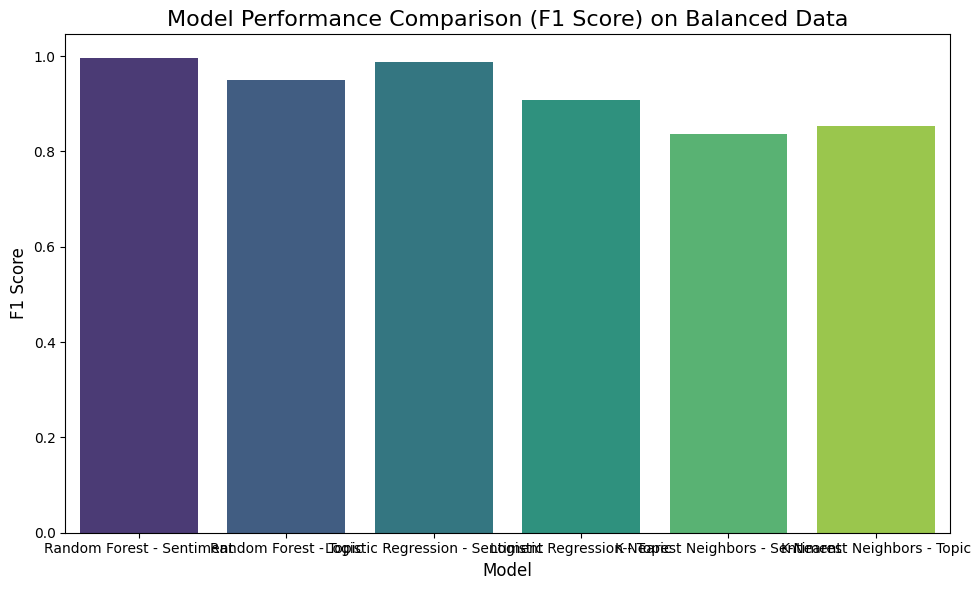

In [31]:
# Convert balanced results to DataFrame
balanced_results_df = pd.DataFrame(balanced_results)
print(balanced_results_df.to_markdown())

# Plot model performance for balanced data
plt.figure(figsize=(10, 6))
sns.barplot(data=balanced_results_df, x='model', y='f1_score', palette='viridis')
plt.title('Model Performance Comparison (F1 Score) on Balanced Data', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.tight_layout()
plt.show()

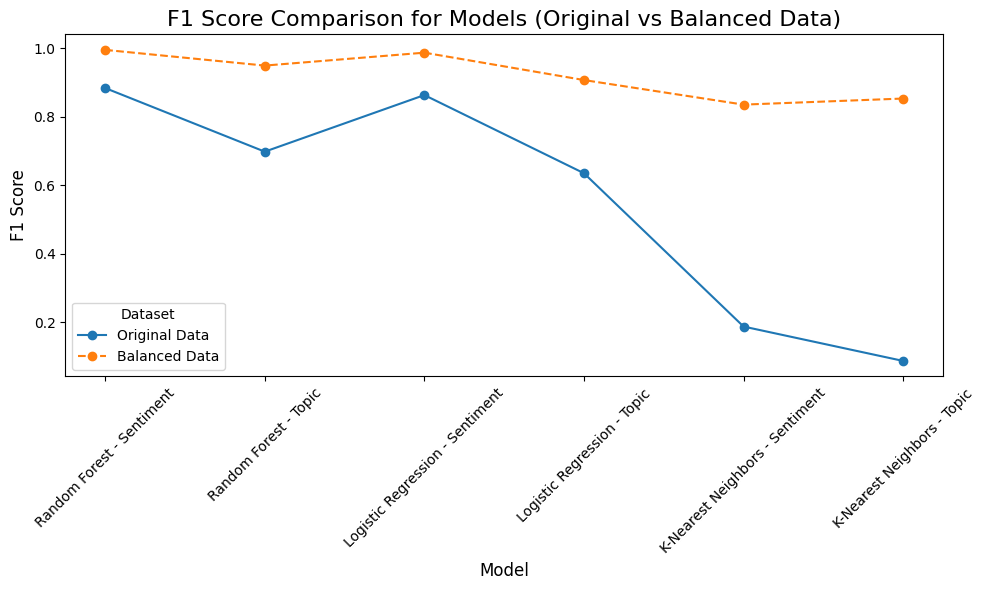

In [32]:
# Ensure necessary libraries are imported
import matplotlib.pyplot as plt

# Combine F1 scores of both original and balanced results
f1_scores_comparison = pd.DataFrame({
    "Model": results_df["model"],
    "F1 Score (Original)": results_df["f1_score"],
    "F1 Score (Balanced)": balanced_results_df["f1_score"],
})

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(f1_scores_comparison["Model"], f1_scores_comparison["F1 Score (Original)"], marker='o', label='Original Data')
plt.plot(f1_scores_comparison["Model"], f1_scores_comparison["F1 Score (Balanced)"], marker='o', label='Balanced Data', linestyle='--')
plt.title('F1 Score Comparison for Models (Original vs Balanced Data)', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(title='Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Hyperparameter Tuning of Best Model

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

# Parameter grid for RandomForestClassifier
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}

# RandomForestClassifier wrapped in MultiOutputClassifier
rf_model = MultiOutputClassifier(RandomForestClassifier(random_state=42))

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=2, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_balanced, y_train_balanced)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 50}
Best Score: nan


Best Parameters: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 50}
Evaluating best model from GridSearchCV...
Model: Best RF - Sentiment
Accuracy: 0.996044825313118
Precision: 0.9960631644715577
Recall: 0.996044825313118
F1 Score: 0.9960448958792263

Classification Report:
               precision    recall  f1-score   support

    negative       0.99      1.00      1.00      1523
     neutral       0.99      1.00      1.00       911
    positive       1.00      0.99      1.00      2117

    accuracy                           1.00      4551
   macro avg       1.00      1.00      1.00      4551
weighted avg       1.00      1.00      1.00      4551



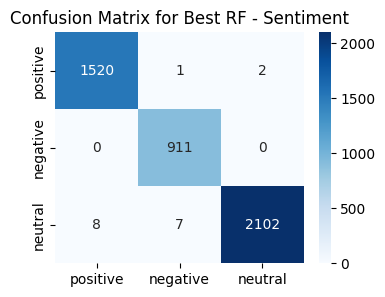

Model: Best RF - Topic
Accuracy: 0.9512195121951219
Precision: 0.9521289526747825
Recall: 0.9512195121951219
F1 Score: 0.9510452869203727

Classification Report:
                   precision    recall  f1-score   support

  Electric Stove       0.91      0.98      0.95       901
   Phone Battery       1.00      1.00      1.00       299
      Phone Case       0.97      0.93      0.95       620
   Phone Charger       0.96      0.97      0.97       615
    Phone Holder       0.94      0.96      0.95       874
     Phone Stand       1.00      0.99      1.00       305
Screen Protector       0.95      0.89      0.92       937

        accuracy                           0.95      4551
       macro avg       0.96      0.96      0.96      4551
    weighted avg       0.95      0.95      0.95      4551



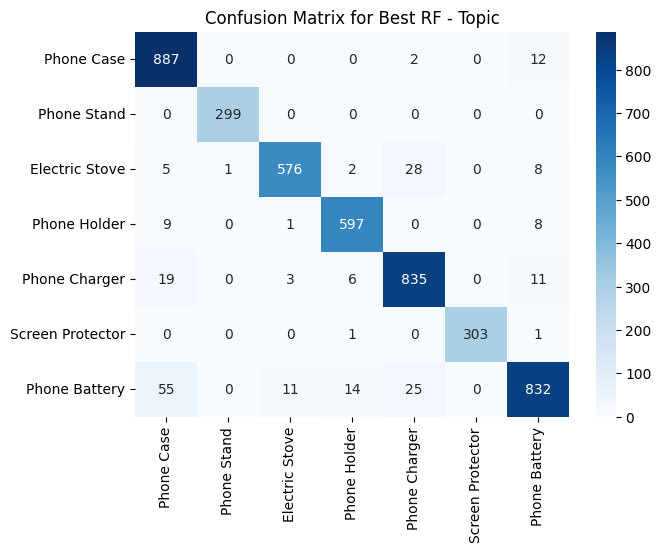

[{'model': 'Best RF - Sentiment',
  'accuracy': 0.996044825313118,
  'precision': 0.9960631644715577,
  'recall': 0.996044825313118,
  'f1_score': 0.9960448958792263},
 {'model': 'Best RF - Topic',
  'accuracy': 0.9512195121951219,
  'precision': 0.9521289526747825,
  'recall': 0.9512195121951219,
  'f1_score': 0.9510452869203727}]

In [34]:
# Get the best model
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluate the best model
print("Evaluating best model from GridSearchCV...")
evaluate_model("Best RF", best_rf_model, X_test_balanced, y_test_balanced)